In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy import units as u
from astropy.io import fits
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0   

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [2]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)

In [3]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from regions import CircleSkyRegion

result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg')
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

In [4]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv')

In [5]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [6]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

In [7]:
from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

#plt.hist(list_t0,bins=int(NDAYS));
#plt.xlabel("$t_0$ (jours)")
#plt.title("Distribution des $t_0$")

In [8]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

#plt.hist(umin,bins=100)
#plt.xlabel("$u_{min}$")
#plt.ylabel("$p(u_{min})$")
#plt.title("Densité de probabilité de $u_{min}$")

In [9]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [10]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [11]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

In [12]:
def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

In [13]:
def linear(x, alpha, beta) : 
    return alpha*x + beta

In [14]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [15]:

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)


F_b = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"].values[i]) * np.pi * pow(df["seeingFwhmEff"].values[i],2))
    
N_pe = []

for i in range (len(F_b)) :
    
    if (df['filter'].values[i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'].values[i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))

bp_atmo = []

for i in range (len(df['observationStartMJD'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp1 = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp1)
        
all_bp = []

for i in range (len(df['observationId'])) :

    if (df['filter'].values[i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'].values[i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'].values[i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'].values[i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'].values[i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'].values[i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

        
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);       

    
    
all_count = []

for obs in all_obs :
    
    all_count.append(obs.countrate())
      
   

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((y * Observation 76)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 77)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 78)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 79)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 80)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 81)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 82)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 83)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Observation 156)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 157)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 158)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 159)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 160)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 161)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 162)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 163)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 236)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 237)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 238)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 239)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 240)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 241)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 242)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 243)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 310)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 311)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 312)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 313)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 314)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 315)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 316)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 317)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 387)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 388)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 389)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 390)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 391)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 392)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 393)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 394)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 464)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 465)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 466)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 467)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 468)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 469)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 470)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 471)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 540)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 541)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 542)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 543)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 544)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 545)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 546)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 547)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 621)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 622)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 623)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 624)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 625)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 626)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 627)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 628)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 700)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 701)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 702)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 703)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 704)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 705)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 706)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 707)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 780)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 781)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 782)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 783)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 784)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 785)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 786)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 787)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 856)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 857)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 858)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 859)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 860)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 861)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 862)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 863)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [16]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [17]:
sigma_N = []

for i in range (len(bp_atmo)) :
    
    sigma_N.append(np.sqrt(N[i]))

t0 = 61420.06948847697
tE = 20
u0 = 0.3438501799852731


(61320.06948847697, 61520.06948847697)

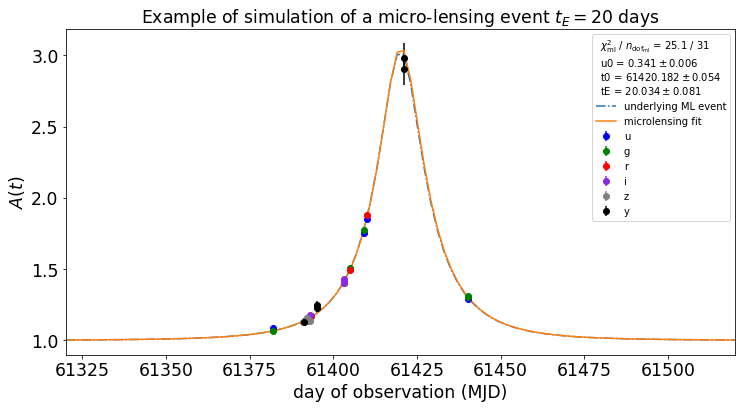

In [35]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) and (df["observationStartMJD"].values[i] <= tmax) and ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        amp_err.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    
        if (df['filter'].values[i] == 'u') :
        
            
            amp_err_u.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
       
        if (df['filter'].values[i] == 'g') :
        
            
            amp_err_g.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'r') :
        
            
            amp_err_r.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'i') :
        
            
            amp_err_i.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'z') :
        
            
            amp_err_z.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'y') :
        
            
            amp_err_y.append(sigma_N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    



#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

(61320.06948847697, 61520.06948847697)

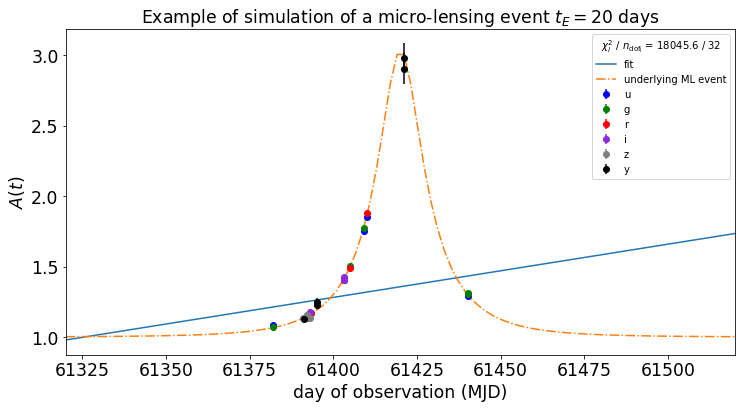

In [36]:
least_squares_line = LeastSquares(x, y, amp_err, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [37]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

2288.6121309908335